# 2021-09-17 Advection

## Last time

* Advection and boundary layers
* The (cell) Péclet number and oscillations

## Today
* Effective use of sparse/structured matrices
* Intro to rootfinding and Newton's method

In [2]:
using Plots
using LinearAlgebra

function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end

fdstencil (generic function with 1 method)

# Advection-diffusion with conservative FD

$$(- \kappa u_x + wu)_x = f$$

In [43]:
function advdiff_conservative(n, kappa, wind, forcing)
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    L = zeros(n, n)
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    for i in 2:n-1
        flux_L = -kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1) + wind * [.5 .5]
        flux_R = -kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1) + wind * [.5 .5]
        weights = fdstencil(xstag[i-1:i], x[i], 1)
        L[i, i-1:i+1] = weights[1] * [flux_L..., 0] + weights[2] * [0, flux_R...]
    end
    L[1, 1] = 1
    rhs[1] = 0
    L[2:end, 1] .= 0
    L[end,end] = 1
    rhs[end] = 0
    L[1:end-1,end] .= 0
    x, L, rhs
end

advdiff_conservative (generic function with 1 method)

# Experiments, The [Péclet number](https://en.wikipedia.org/wiki/P%C3%A9clet_number)

\begin{align}
(- \kappa u_x + wu)_x &= f & \mathrm{Pe}_h &= \frac{h \lvert w \rvert}{\kappa}
\end{align}

minimum(diff(x)) = 0.0512820512820511


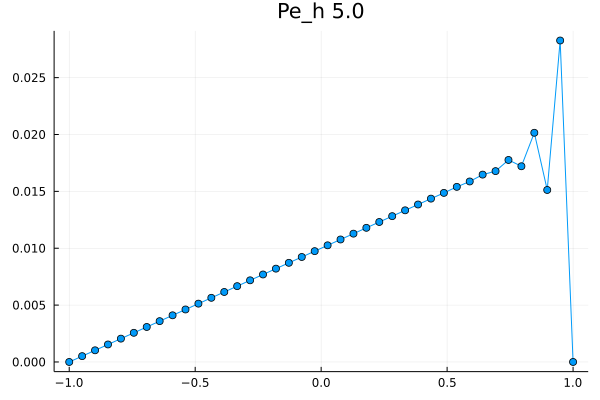

In [44]:
n = 40; h = 2/n
kappa = 1
wind = 100
x, L, rhs = advdiff_conservative(n, x -> kappa, wind, one)
@show minimum(diff(x))
plot(x, L \ rhs, marker=:auto, legend=:none, title="Pe_h $(wind*h/kappa)")

# Upwinded discretization

Idea: incoming **advective flux** should depend only on upwind value, outgoing should depend only on my value.

In [49]:
function advdiff_upwind(n, kappa, wind, forcing)
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    L = zeros(n, n)
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    for i in 2:n-1
        flux_L = -kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])  # <--- was [.5 .5]
        flux_R = -kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])  # <--- was [.5 .5]
        weights = fdstencil(xstag[i-1:i], x[i], 1)
        L[i, i-1:i+1] = weights[1] * [flux_L..., 0] + weights[2] * [0, flux_R...]
    end
    L[1, 1] = 1
    rhs[1] = 0
    L[2:end, 1] .= 0
    L[end,end] = 1
    rhs[end] = 0
    L[1:end-1,end] .= 0
    x, L, rhs
end

advdiff_upwind (generic function with 1 method)

# Try it for robustness

minimum(diff(x)) = 0.0512820512820511


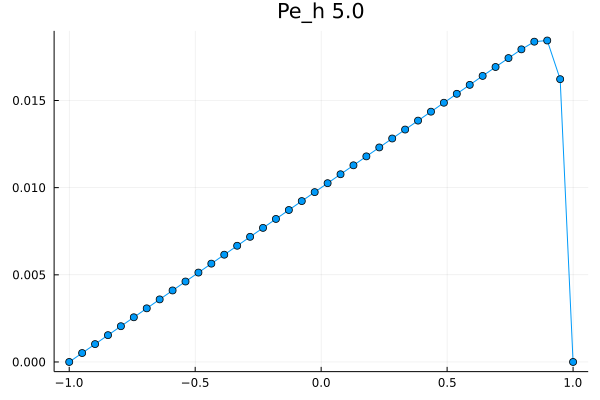

In [46]:
n = 40; h = 2/n
kappa = 1
wind = 100
x, L, rhs = advdiff_upwind(n, x -> kappa, wind, one)
@show minimum(diff(x))
plot(x, L \ rhs, marker=:auto, legend=:none, title="Pe_h $(wind*h/kappa)")

### What is the order of accuracy of this upwind discretization?

# How expensive is `\`?

In [36]:

x, L, rhs = advdiff_upwind(2500, x -> kappa, wind, one)
@time L \ x;

  0.122381 seconds (5 allocations: 47.713 MiB)


In [27]:
function elapsed_solve(n)
    x, L, rhs = advdiff_upwind(n, x -> kappa, wind, one)
    @elapsed L \ x
end
ns = (1:5) * 1000
times = elapsed_solve.(ns)

5-element Vector{Float64}:
 0.008166121
 0.111934549
 0.183590587
 0.438108566
 0.825597242

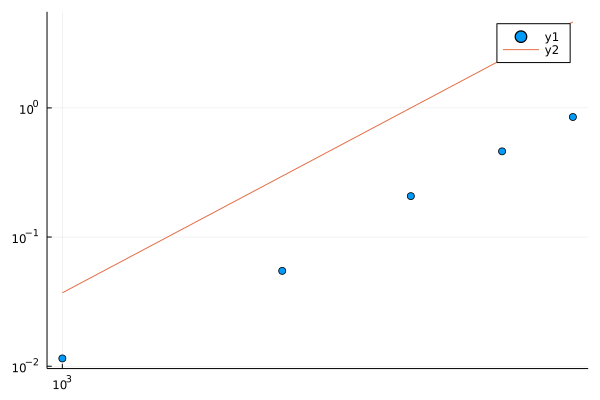

┌ Warning: No strict ticks found
└ @ PlotUtils /home/jed/.julia/packages/PlotUtils/n4I4Q/src/ticks.jl:295
┌ Warning: No strict ticks found
└ @ PlotUtils /home/jed/.julia/packages/PlotUtils/n4I4Q/src/ticks.jl:295


In [11]:
scatter(ns, times, xscale=:log10, yscale=:log10)
plot!(ns, (ns/3000).^3)

## How long would $n=10000$ take to solve?

## How much memory would $n=10000$ take?

# Sparsity

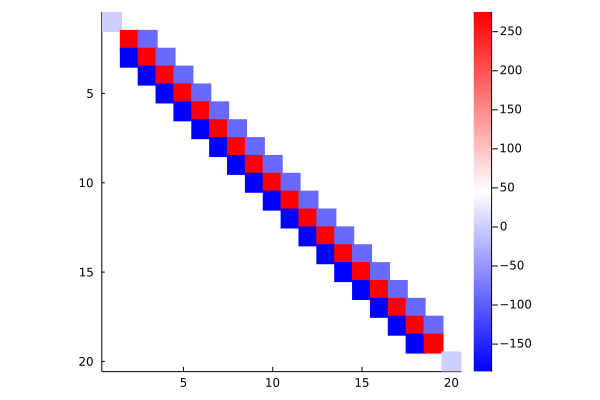

In [19]:
x, L, rhs = advdiff_upwind(20, one, 10, one)
spy(L, marker=(:square, 10), c=:bwr)

In [20]:
using SparseArrays
sparse(L)

20×20 SparseMatrixCSC{Float64, Int64} with 54 stored entries:
⠱⣦⡀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀
⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠈⠻⢆

# How does solving with the sparse matrix scale?

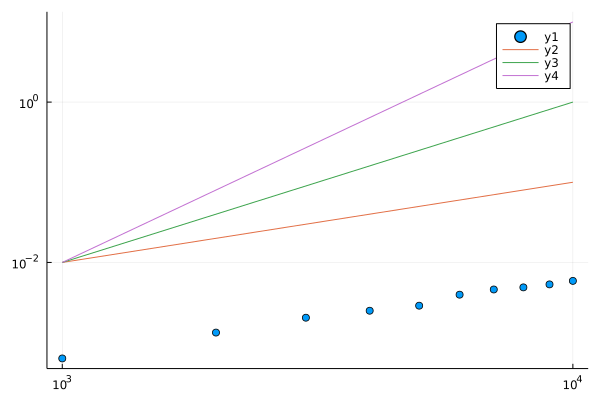

In [26]:
function elapsed_solve(n)
    x, L, rhs = advdiff_upwind(n, x -> kappa, wind, one)
    L = sparse(L)
    @elapsed L \ x
end
ns = (1:10) * 1000
times = elapsed_solve.(ns)
scatter(ns, times, xscale=:log10, yscale=:log10)
plot!([n -> 1e-2*n/1000, n -> 1e-2*(n/1000)^2, n -> 1e-2*(n/1000)^3])

## How much memory is needed?

# [SparseArrays](https://docs.julialang.org/en/v1/stdlib/SparseArrays/) Compressed Sparse Column (CSC)



In [30]:
# starting with a dense matrix
A = sparse([1 0 0 -2; 0 3.14 0 .4; 5.1 0 0 .06])

3×4 SparseMatrixCSC{Float64, Int64} with 6 stored entries:
 1.0   ⋅     ⋅   -2.0
  ⋅   3.14   ⋅    0.4
 5.1   ⋅     ⋅    0.06

In [38]:
@show A.colptr
@show A.rowval
A.nzval

A.colptr = [1, 3, 4, 4, 7]
A.rowval = [1, 3, 2, 1, 2, 3]


6-element Vector{Float64}:
  1.0
  5.1
  3.14
 -2.0
  0.4
  0.06

* CSC (or, more commonly outside Matlab/Julia, row-based CSR) are good for matrix operations (multiplication, solve), but sometimes inconvenient to assemble.

# Matrix assembly using COO format

In [39]:
A

3×4 SparseMatrixCSC{Float64, Int64} with 6 stored entries:
 1.0   ⋅     ⋅   -2.0
  ⋅   3.14   ⋅    0.4
 5.1   ⋅     ⋅    0.06

In [42]:
sparse([1, 1, 2, 2, 3, 3],
       [1, 4, 2, 4, 1, 4],
       [1, -2, 3.14, .4, 5.1, .06])

3×4 SparseMatrixCSC{Float64, Int64} with 6 stored entries:
 1.0   ⋅     ⋅   -2.0
  ⋅   3.14   ⋅    0.4
 5.1   ⋅     ⋅    0.06

# Upwind advection-diffusion solver using COO

In [ ]:
function advdiff_sparse(n, kappa, wind, forcing)
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    rows = [1, n]
    cols = [1, n]
    vals = [1., 1.] # diagonals entries (float)
    rhs[[1,n]] .= 0 # boundary condition
    for i in 2:n-1
        flux_L = -kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])  # <--- was [.5 .5]
        flux_R = -kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])  # <--- was [.5 .5]
        weights = fdstencil(xstag[i-1:i], x[i], 1)
        append!(rows, [i,i,i])
        append!(cols, i-1:i+1)
        append!(vals, weights[1] * [flux_L..., 0] + weights[2] * [0, flux_R...])
    end
    L = sparse(rows, cols, vals)
    x, L, rhs
end

# Assembly cost

minimum(diff(x)) = 0.005012531328320691


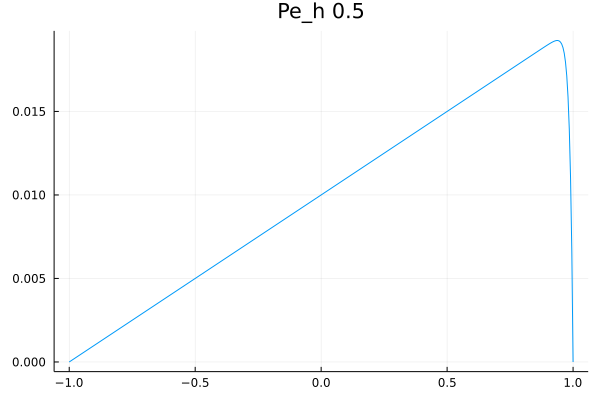

In [56]:
n = 400; h = 2/n
kappa = 1
wind = 100
x, L, rhs = advdiff_sparse(n, x -> kappa, wind, one)
@show minimum(diff(x))
plot(x, L \ rhs, legend=:none, title="Pe_h $(wind*h/kappa)")

In [64]:
n = 10000
@time advdiff_upwind(n, one, 1, one);
@time advdiff_sparse(n, one, 1, one);

  0.288048 seconds (708.34 k allocations: 803.497 MiB, 5.85% gc time)
  0.107315 seconds (698.92 k allocations: 44.198 MiB, 25.41% gc time)


# Nonlinear problems and rootfinding

We want to solve problems like
$$ -(|u_x|^{p-2} u_x)_x + (u^2)_x = 0 $$

For linear problems, we found $u$ such that $L u = b$ using linear algebra.

For nonlinear problems, we'll need to find $u$ such that $F(u) = 0$.

# An algorithm: Bisection

Bisection is a rootfinding technique that starts with an interval $[a,b]$ containing a root and does not require derivatives. Suppose $f$ is continuous. What is a **sufficient** condition for $f$ to have a root on $[a,b]$?

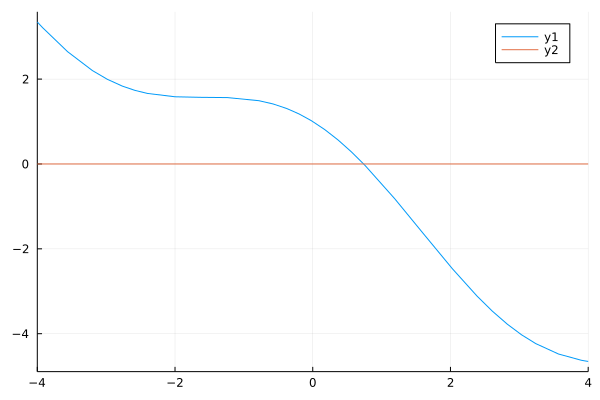

In [65]:
hasroot(f, a, b) = f(a) * f(b) < 0

f(x) =  cos(x) - x
plot([f, x->0], xlims=(-4,4))

In [66]:
hasroot(f, 0, 1)

true

# Bisection

In [67]:
function bisect(f, a, b, tol)
    mid = (a + b) / 2
    if abs(b - a) < tol
        return mid
    elseif hasroot(f, a, mid)
        return bisect(f, a, mid, tol)
    else
        return bisect(f, mid, b, tol)
    end
end

x0 = bisect(f, -1, 3, 1e-5)
x0, f(x0)

(0.7390861511230469, -1.7035832658995886e-6)

# How fast does it converge?

In [68]:
function bisect_hist(f, a, b, tol)
    mid = (a + b) / 2
    if abs(b - a) < tol
        return [mid]
    elseif hasroot(f, a, mid)
        return prepend!(bisect_hist(f, a, mid, tol), [mid])
    else
        return prepend!(bisect_hist(f, mid, b, tol), [mid])
    end
end

bisect_hist (generic function with 1 method)

In [69]:
bisect_hist(f, -1, 3, 1e-4)

17-element Vector{Float64}:
 1.0
 0.0
 0.5
 0.75
 0.625
 0.6875
 0.71875
 0.734375
 0.7421875
 0.73828125
 0.740234375
 0.7392578125
 0.73876953125
 0.739013671875
 0.7391357421875
 0.73907470703125
 0.739105224609375

# Let's plot the error

$$ \lvert \texttt{bisect}^k(f, a, b) - r \rvert, \quad k = 1, 2, \dotsc $$

where $r$ is the true root, $f(r) = 0$.

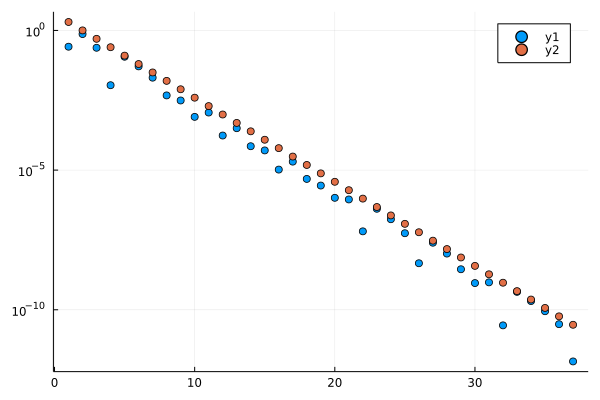

In [70]:
r = bisect(f, -1, 3, 1e-14) # what are we trusting?
hist = bisect_hist(f, -1, 3, 1e-10)
scatter( abs.(hist .- r), yscale=:log10)
ks = 1:length(hist)
scatter!(ks, 4 * 0.5 .^ ks)

Evidently the error $e_k = x_k - x_*$ after $k$ bisections satisfies the bound
$$ |e^k| \le c 2^{-k} . $$

# Convergence classes

A convergent rootfinding algorithm produces a sequence of approximations $x_k$ such that $$\lim_{k \to \infty} x_k \to x_*$$ where $f(x_*) = 0$.  For analysis, it is convenient to define the errors $e_k = x_k - x_*$. We say that an iterative algorithm is **$q$-linearly convergent** if $$\lim_{k \to \infty} |e_{k+1}| / |e_k| = \rho < 1.$$  (The $q$ is for "quotient".)  A smaller convergence factor $\rho$ represents faster convergence.  A slightly weaker condition ($r$-linear convergence or just **linear convergence**) is that
$$ |e_k| \le \epsilon_k $$
for all sufficiently large $k$ when the sequence $\{\epsilon_k\}$ converges $q$-linearly to 0.

### Bisection: A = q-linearly convergent, B = r-linearly convergent, C = neither

# Remarks on bisection

* Specifying an interval is often inconvenient
* An interval in which the function changes sign guarantees convergence (robustness)
* No derivative information is required
* Roots of even degree are problematic
* A bound on the solution error is directly available
* The convergence rate is modest -- one iteration per bit of accuracy
* **No good generalization to higher dimensions**

## Newton-Raphson Method

Much of numerical analysis reduces to [Taylor series](https://en.wikipedia.org/wiki/Taylor_series), the approximation
$$ f(x) = f(x_0) + f'(x_0) (x-x_0) + f''(x_0) (x - x_0)^2 / 2 + \underbrace{\dotsb}_{O((x-x_0)^3)} $$
centered on some reference point $x_0$.

In numerical computation, it is exceedingly rare to look beyond the first-order approximation
$$ \tilde f_{x_0}(x) = f(x_0) + f'(x_0)(x - x_0) . $$
Since $\tilde f_{x_0}(x)$ is a linear function, we can explicitly compute the unique solution of $\tilde f_{x_0}(x) = 0$ as
$$ x = x_0 - f(x_0) / f'(x_0) . $$
This is Newton's Method (aka Newton-Raphson or Newton-Raphson-Simpson) for finding the roots of differentiable functions.

# An implementation

In [71]:
function newton(f, fp, x0; tol=1e-8, verbose=false)
    x = x0
    for k in 1:100 # max number of iterations
        fx = f(x)
        fpx = fp(x)
        if verbose
            println("[$k] x=$x  f(x)=$fx  f'(x)=$fpx")
        end
        if abs(fx) < tol
            return x, fx, k
        end
        x = x - fx / fpx
    end  
end
eps = 1e-10
newton(x -> eps*(cos(x) - x), x -> eps*(-sin(x) - 1), 1; tol=1e-15, verbose=true)

[1] x=1  f(x)=-4.596976941318603e-11  f'(x)=-1.8414709848078966e-10
[2] x=0.7503638678402439  f(x)=-1.8923073822117444e-12  f'(x)=-1.6819049529414878e-10
[3] x=0.7391128909113617  f(x)=-4.645589899077152e-15  f'(x)=-1.6736325442243014e-10
[4] x=0.739085133385284  f(x)=-2.847205804457076e-20  f'(x)=-1.6736120293089506e-10


(0.739085133385284, -2.847205804457076e-20, 4)

# That's really fast!

* 10 digits of accuracy in 4 iterations.
* How is this convergence test different from the one we used for bisection?
* How can this break down?

$$ x_{k+1} = x_k - f(x_k)/f'(x_k) $$

In [72]:
newton(x -> cos(x) - x, x -> -sin(x) - 1, 3*pi/2; verbose=true)

[1] x=4.71238898038469  f(x)=-4.71238898038469  f'(x)=0.0


LoadError: DomainError with Inf:
cos(x) is only defined for finite x.

# Convergence of fixed-point iteration

Consider the iteration
$$x_{k+1} = g(x_k)$$
where $g$ is a continuously differentiable function.
Suppose that there exists a fixed point $x_* = g(x_*)$.  By the [mean value theorem](https://en.wikipedia.org/wiki/Mean_value_theorem), we have that
$$ x_{k+1} - x_* = g(x_k) - g(x_*) = g'(c_k) (x_k - x_*) $$
for some $c_i$ between $x_k$ and $x_*$.

Taking absolute values, $$|e_{k+1}| = |g'(c_k)| |e_k|,$$ which converges to zero if $|g'(c_k)| < 1$.

## Exercise

* Write Newton's method for $f(x) = 0$ from initial guess $x_0$ as a fixed point method.
* Suppose the Newton iterates $x_k$ converge to a simple root $x_*$, $x_k \to x_*$. What is $\lvert g'(x_*) \rvert$ for Newton's method?